# Datawrangling the pelvic floor scans of the mouse samples
Let's see what we did there...

In [1]:
import platform
import os
import glob
import pandas
import dask
from dask.distributed import Client, LocalCluster
import dask_image.imread
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
import seaborn
import numpy
from tqdm.auto import tqdm, trange
import imageio

In [2]:
# Import our own parsing functions which we've added as submodule
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [4]:
# Start cluster and client now, after setting tempdir
try:
    cluster = LocalCluster()
except PermissionError:
    print('Mount the Fast_SSD, otherwise we cannot use it for saving the temporary files!')
    print('Then rerun this cell.')
client = Client(cluster)

In [5]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [6]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [7]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300

In [8]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [9]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [10]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-djonov')
elif 'Darwin' in platform.system():
    # First mount smb://resstore.unibe.ch/ana_rs_djonov/data in the Finder
    FastSSD = False
    BasePath = os.path.join('/Volumes/data/')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('V:\\')
        else:
            BasePath = os.path.join('V:\\')
Root = os.path.join(BasePath, 'Aaldijk')
print('We are loading all the data from %s' % Root)

We are loading all the data from /home/habi/research-storage-djonov/Aaldijk


In [11]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [167]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /home/habi/P/Documents/Dea-Beckenboden/Output/1270bf4


In [13]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [14]:
# Get *all* log files, unsorted but faster than with glob
print('Searching for all log files in %s' % Root)
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

Searching for all log files in /home/habi/research-storage-djonov/Aaldijk


In [15]:
# Drop all non-mouse scans
for c, row in Data.iterrows():
    if 'Mouse' not in row.LogFile:
        Data.drop([c], inplace=True)
Data.reset_index(inplace=True)

In [16]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [17]:
#Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

In [18]:
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*.csv')) for f in Data['Folder']]

In [19]:
# Check for samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not len(row.XYAlignment):
            if not any(x in row.LogFile for x in ['rectmp.log']):
                # 'rectmp.log' because we only exclude it afterwards :)
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root)+1:])

In [20]:
# Get rid of all logfiles that we don't want
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:  # drop all non-rec folders
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:  # drop all partial reconstructions which might be there from synchronization
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:  # drop all temporary logfiles
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [21]:
# Generate us some meaningful colums
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['SampleName'] = [sn.split('_')[0] for sn in Data['Sample']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [22]:
Data.SampleName.unique()

array(['Mouse01', 'Mouse02'], dtype=object)

In [23]:
# if not len(Data.SampleName.unique()) == 1:
#     print('Something went wrong with the extration of the common sample name')

In [24]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [25]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 25 folders with reconstructions


In [26]:
# Get scanning parameters to doublecheck from logfiles
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Voltage'] = [voltage(log) for log in Data['LogFile']]
Data['Current'] = [current(log) for log in Data['LogFile']]
Data['Voxelsize'] = [pixelsize(log, rounded=True) for log in Data['LogFile']]
Data['CameraWindow'] = [projection_size(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposure(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['Stacks'] = [stacks(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [duration(log) for log in Data['LogFile']]

In [27]:
# Sort our dataframe by scan date
Data.sort_values(by='Scan date', inplace=True, ignore_index=True)

In [28]:
Data.Voltage.unique()

array([60.])

In [29]:
Data.Current.unique()

array([140.])

In [30]:
Data.Averaging.unique()

array([False])

In [31]:
Data.Voxelsize.unique()

array([15.,  9.])

In [32]:
Data['CameraWindow'].unique()

array([(3072, 1944), (2457, 1944)], dtype=object)

In [33]:
# Get reconstruction parameters to doublecheck from logfiles
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [defectpixelmasking(log) for log in Data['LogFile']]
Data['ROI'] = [region_of_interest(log) for log in Data['LogFile']]

In [34]:
Data[['Sample', 'Scan', 'ROI']]

,Sample,Scan,ROI
0,Mouse01_Nativ_20220905,rec,"(2622, 678, 445, 2389)"
1,Mouse02_Nativ_20220905,rec,"(2573, 629, 567, 2511)"
2,Mouse01_Lugol_15pct_20220914,rec,"(2642, 698, 500, 2444)"
3,Mouse01_Lugol_15pct_20220921,rec,"(2517, 573, 640, 2584)"
4,Mouse01_Lugol_15pct_20220928,rec,"(2368, 424, 715, 2659)"
5,Mouse01_Lugol_15pct_20221017,rec,"(2369, 425, 652, 2596)"
6,Mouse01_Lugol_15pct_20221027,rec,"(2420, 476, 530, 2474)"
7,Mouse01_Lugol_15pct_20221107,rec,"(2414, 470, 656, 2600)"
8,Mouse01_Lugol_15pct_20221117,rec,"(2395, 451, 564, 2508)"
9,Mouse01_Lugol_15pct_20221128,rec,"(2424, 480, 645, 2589)"


In [35]:
Data['Grayvalue'].unique()

array([0.1     , 0.151022])

In [36]:
Data['RingartefactCorrection'].unique()

array([1, 0])

In [37]:
for c,row in Data.iterrows():
    if row.Grayvalue != 0.1:
        print(row.Sample, row.Grayvalue)

Mouse01_Lugol_15pct_20230510 0.151022


In [38]:
for c,row in Data.iterrows():
    if not row.RingartefactCorrection:
        print(row.Sample, row.RingartefactCorrection)

Mouse01_Lugol_15pct_20230510 0


In [39]:
Data[['Sample', 'Scan', 'Grayvalue', 'RingartefactCorrection', 'BeamHardeningCorrection', 'DefectPixelMasking']]

,Sample,Scan,Grayvalue,RingartefactCorrection,BeamHardeningCorrection,DefectPixelMasking
0,Mouse01_Nativ_20220905,rec,0.100000,1,0,0
1,Mouse02_Nativ_20220905,rec,0.100000,1,0,0
2,Mouse01_Lugol_15pct_20220914,rec,0.100000,1,0,0
3,Mouse01_Lugol_15pct_20220921,rec,0.100000,1,0,0
4,Mouse01_Lugol_15pct_20220928,rec,0.100000,1,0,0
5,Mouse01_Lugol_15pct_20221017,rec,0.100000,1,0,0
6,Mouse01_Lugol_15pct_20221027,rec,0.100000,1,0,0
7,Mouse01_Lugol_15pct_20221107,rec,0.100000,1,0,0
8,Mouse01_Lugol_15pct_20221117,rec,0.100000,1,0,0
9,Mouse01_Lugol_15pct_20221128,rec,0.100000,1,0,0


In [40]:
# Calculate time 'spent' since start
Data['Time passed'] = [sd - Data['Scan date'].min() for sd in Data['Scan date']]
# Also extract days, rounded
Data['Days passed'] = [t.round('d') for t in Data['Time passed']]

In [41]:
Data[['Sample', 'Scan date', 'Time passed', 'Days passed']]

,Sample,Scan date,Time passed,Days passed
0,Mouse01_Nativ_20220905,2022-09-05 12:05:31,0 days 00:00:00,0 days
1,Mouse02_Nativ_20220905,2022-09-05 14:43:22,0 days 02:37:51,0 days
2,Mouse01_Lugol_15pct_20220914,2022-09-14 11:48:21,8 days 23:42:50,9 days
3,Mouse01_Lugol_15pct_20220921,2022-09-21 11:45:53,15 days 23:40:22,16 days
4,Mouse01_Lugol_15pct_20220928,2022-09-28 12:46:39,23 days 00:41:08,23 days
5,Mouse01_Lugol_15pct_20221017,2022-10-17 13:08:30,42 days 01:02:59,42 days
6,Mouse01_Lugol_15pct_20221027,2022-10-27 14:58:04,52 days 02:52:33,52 days
7,Mouse01_Lugol_15pct_20221107,2022-11-07 14:10:21,63 days 02:04:50,63 days
8,Mouse01_Lugol_15pct_20221117,2022-11-17 11:34:45,72 days 23:29:14,73 days
9,Mouse01_Lugol_15pct_20221128,2022-11-28 12:20:20,84 days 00:14:49,84 days


Some consistency checks

In [42]:
# Check ringremoval parameters
for machine in Data['Scanner'].unique():
    print('For the %s we have '
          'ringartefact-correction values of %s' % (machine,
                                                    Data[Data.Scanner==machine]['RingartefactCorrection'].unique()))

For the SkyScan 2214 we have ringartefact-correction values of [1 0]


In [43]:
# Check beamhardening parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'beamhardening correction values of %s' % (scanner,
                                                     Data[Data.Scanner==scanner]['BeamHardeningCorrection'].unique()))

For the SkyScan 2214 we have beamhardening correction values of [0]


In [44]:
# Check defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'defect pixel masking values of %s' % (scanner,
                                                 Data[Data.Scanner==scanner]['DefectPixelMasking'].unique()))

For the SkyScan 2214 we have defect pixel masking values of [0]


In [45]:
# Check defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'reconstruction gray values of %s' % (scanner,
                                                Data[Data.Scanner==scanner]['Grayvalue'].unique()))

For the SkyScan 2214 we have reconstruction gray values of [0.1      0.151022]


Check and display scan times

In [46]:
Data['Scan time total'] = [ st * stk  for st, stk in zip(Data['Scan time'], Data['Stacks'])]

In [47]:
# # https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
# columns = list(Data)
# columns.remove('Folder') 
# columns.remove('Sample')
# columns.remove('LogFile')
# columns.remove('Reconstructions')
# columns.remove('Number of reconstructions')
# columns.remove('Grayvalue')
# columns.remove('Scan time')
# columns.remove('Scan time total')
# columns.remove('Scan date')
# print(columns)
# for col in columns:
#     print(col)
#     print(Data[col].unique())
#     print(80*'-')    

In [48]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
roundto = 2
if len(Data['Voxelsize'].round(roundto).unique()) > 1:
    print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
    for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
        print('-', vs, 'um for ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], roundto):
                print(os.path.join(row['Sample'], row['Scan']), end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

We scanned all datasets with 2 different voxel sizes
- 9.0 um for Mouse01_Lugol_15pct_20230510/rec_09um, 
- 15.0 um for Mouse01_Nativ_20220905/rec, Mouse02_Nativ_20220905/rec, Mouse01_Lugol_15pct_20220914/rec, Mouse01_Lugol_15pct_20220921/rec, Mouse01_Lugol_15pct_20220928/rec, Mouse01_Lugol_15pct_20221017/rec, Mouse01_Lugol_15pct_20221027/rec, Mouse01_Lugol_15pct_20221107/rec, Mouse01_Lugol_15pct_20221117/rec, Mouse01_Lugol_15pct_20221128/rec, Mouse01_Lugol_15pct_20221209/rec, Mouse01_Lugol_15pct_20221223/rec, Mouse01_Lugol_15pct_20230104/rec, Mouse01_Lugol_15pct_20230113/rec, Mouse01_Lugol_15pct_20230125/rec, Mouse01_Lugol_15pct_20230203/rec, Mouse01_Lugol_15pct_20230214/rec, Mouse01_Lugol_15pct_20230227/rec, Mouse01_Lugol_15pct_20230317/rec, Mouse01_Lugol_15pct_20230330/rec, Mouse01_Lugol_15pct_20230411/rec, Mouse01_Lugol_15pct_20230421/rec, Mouse01_Lugol_15pct_20230501/rec, Mouse02_Lugol_15pct_20230501/rec, 


In [49]:
Data[['Sample', 'Scan',
      'BeamHardeningCorrection', 'DefectPixelMasking',
      'RingartefactCorrection', 'Grayvalue',]]

,Sample,Scan,BeamHardeningCorrection,DefectPixelMasking,RingartefactCorrection,Grayvalue
0,Mouse01_Nativ_20220905,rec,0,0,1,0.100000
1,Mouse02_Nativ_20220905,rec,0,0,1,0.100000
2,Mouse01_Lugol_15pct_20220914,rec,0,0,1,0.100000
3,Mouse01_Lugol_15pct_20220921,rec,0,0,1,0.100000
4,Mouse01_Lugol_15pct_20220928,rec,0,0,1,0.100000
5,Mouse01_Lugol_15pct_20221017,rec,0,0,1,0.100000
6,Mouse01_Lugol_15pct_20221027,rec,0,0,1,0.100000
7,Mouse01_Lugol_15pct_20221107,rec,0,0,1,0.100000
8,Mouse01_Lugol_15pct_20221117,rec,0,0,1,0.100000
9,Mouse01_Lugol_15pct_20221128,rec,0,0,1,0.100000


In [50]:
# if len(Data['Grayvalue'].unique()) > 1:
#     print('We reconstructed the datasets with different maximum gray values, namely')
#     for gv in Data['Grayvalue'].unique():
#         print(gv, 'for Samples ', end='')
#         for c, row in Data.iterrows():
#             if float(gv) == row['Grayvalue']:
#                 print(os.path.join(row['Sample'], row['Scan']), end=', ')
#         print('')
# else:
#     print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

In [51]:
# Data[['Sample', 'Scan',
#       'Voxelsize', 'Scanner',
#       'Scan date', 'CameraWindow', 'RotationStep', 'Averaging',
#       'Scan time', 'Stacks', 'Scan time total']]

In [52]:
# Get an overview over the total scan time
# Nice output based on https://stackoverflow.com/a/8907407/323100
total_seconds = int(Data['Scan time total'].sum())
hours, remainder = divmod(total_seconds,60*60)
minutes, seconds = divmod(remainder,60)
print('In total, we scanned for %s hours and %s minutes)' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Scan time total'].sum())
    hours, remainder = divmod(total_seconds,60*60)
    minutes, seconds = divmod(remainder,60)
    print('\t - Of these, we scanned %s hours and %s minutes on the %s,'
          ' for %s scans' % (hours,
                             minutes,
                             machine,
                             len(Data[Data['Scanner'] == machine])))

In total, we scanned for 52 hours and 36 minutes)
	 - Of these, we scanned 52 hours and 36 minutes on the SkyScan 2214, for 25 scans


In [53]:
Data[['Sample', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel('Mouse.Details.xlsx')

In [54]:
Data[['Sample', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow',
      'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel(os.path.join(Root,'Mouse.Details.xlsx'))

In [55]:
Data.tail()

,index,LogFile,Folder,XYAlignment,Sample,SampleName,Scan,Reconstructions,Number of reconstructions,Scanner,...,Scan date,Scan time,Grayvalue,RingartefactCorrection,BeamHardeningCorrection,DefectPixelMasking,ROI,Time passed,Days passed,Scan time total
20,95,/home/habi/research-storage-djonov/Aaldijk/Mou...,/home/habi/research-storage-djonov/Aaldijk/Mou...,[],Mouse01_Lugol_15pct_20230411,Mouse01,rec,[/home/habi/research-storage-djonov/Aaldijk/Mo...,1941,SkyScan 2214,...,2023-04-11 12:25:39,6818.0,0.100000,1,0,0,"(2403, 459, 507, 2451)",218 days 00:20:08,218 days,6818.0
21,56,/home/habi/research-storage-djonov/Aaldijk/Mou...,/home/habi/research-storage-djonov/Aaldijk/Mou...,[],Mouse01_Lugol_15pct_20230421,Mouse01,rec,[/home/habi/research-storage-djonov/Aaldijk/Mo...,1941,SkyScan 2214,...,2023-04-21 11:53:00,6502.0,0.100000,1,0,0,"(2630, 686, 365, 2309)",227 days 23:47:29,228 days,6502.0
22,78,/home/habi/research-storage-djonov/Aaldijk/Mou...,/home/habi/research-storage-djonov/Aaldijk/Mou...,[],Mouse01_Lugol_15pct_20230501,Mouse01,rec,[/home/habi/research-storage-djonov/Aaldijk/Mo...,1941,SkyScan 2214,...,2023-05-01 14:07:43,8934.0,0.100000,1,0,0,"(2520, 576, 620, 2564)",238 days 02:02:12,238 days,8934.0
23,89,/home/habi/research-storage-djonov/Aaldijk/Mou...,/home/habi/research-storage-djonov/Aaldijk/Mou...,[],Mouse02_Lugol_15pct_20230501,Mouse02,rec,[/home/habi/research-storage-djonov/Aaldijk/Mo...,1941,SkyScan 2214,...,2023-05-01 17:08:20,8639.0,0.100000,1,0,0,"(2570, 626, 667, 2611)",238 days 05:02:49,238 days,8639.0
24,83,/home/habi/research-storage-djonov/Aaldijk/Mou...,/home/habi/research-storage-djonov/Aaldijk/Mou...,[],Mouse01_Lugol_15pct_20230510,Mouse01,rec_09um,[/home/habi/research-storage-djonov/Aaldijk/Mo...,2995,SkyScan 2214,...,2023-05-10 13:10:00,9649.0,0.151022,0,0,0,False,247 days 01:04:29,247 days,9649.0


In [56]:
# Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp')))[0] for f in Data['Folder']]
# Data['PreviewImage'] = [dask_image.imread.imread(pip)
#                         if pip
#                         else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [57]:
# Make an approximately square overview image
lines = 3

In [58]:
# for c, row in Data.iterrows():
#     plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     plt.imshow(row.PreviewImage.squeeze())
#     plt.title('%s at day %s' % (row['SampleName'], row['Days passed'].days))
#     plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                   'um',
#                                   color='black',
#                                   frameon=True))
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig(os.path.join(Root, 'ScanOverviews.Mouse.png'),
#             bbox_inches='tight')
# plt.show()

In [59]:
# Load all reconstructions into ephemereal DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/25 [00:00<?, ?it/s]

In [60]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [82]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [83]:
Data[['Sample', 'Scan', 'Size', 'ROI', 'RingartefactCorrection', 'Grayvalue']]

,Sample,Scan,Size,ROI,RingartefactCorrection,Grayvalue
0,Mouse01_Nativ_20220905,rec,"(1941, 1944, 1944)","(2622, 678, 445, 2389)",1,0.1
1,Mouse01_Lugol_15pct_20220914,rec,"(1941, 1944, 1944)","(2642, 698, 500, 2444)",1,0.1
2,Mouse01_Lugol_15pct_20220921,rec,"(1941, 1944, 1944)","(2517, 573, 640, 2584)",1,0.1
3,Mouse01_Lugol_15pct_20220928,rec,"(1941, 1944, 1944)","(2368, 424, 715, 2659)",1,0.1
4,Mouse01_Lugol_15pct_20221017,rec,"(1941, 1944, 1944)","(2369, 425, 652, 2596)",1,0.1
5,Mouse01_Lugol_15pct_20221027,rec,"(1941, 1944, 1944)","(2420, 476, 530, 2474)",1,0.1
6,Mouse01_Lugol_15pct_20221107,rec,"(1941, 1944, 1944)","(2414, 470, 656, 2600)",1,0.1
7,Mouse01_Lugol_15pct_20221117,rec,"(1941, 1944, 1944)","(2395, 451, 564, 2508)",1,0.1
8,Mouse01_Lugol_15pct_20221128,rec,"(1941, 1944, 1944)","(2424, 480, 645, 2589)",1,0.1
9,Mouse01_Lugol_15pct_20221209,rec,"(1941, 1944, 1944)","(2017, 73, 275, 2219)",1,0.1


In [84]:
# Check defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'reconstruction gray values of %s' % (scanner,
                                                Data[Data.Scanner==scanner]['Size'].unique()))

For the SkyScan 2214 we have reconstruction gray values of [(1941, 1944, 1944)]


In [85]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [86]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='Middle images', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Sample'],
                                                            row['Scan'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute().squeeze()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute().squeeze()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute().squeeze()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

Middle images:   0%|          | 0/22 [00:00<?, ?it/s]

Mouse01_Nativ_20220905/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20220914/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20220921/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20220928/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221017/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221027/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221107/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221117/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221128/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221209/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221223/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230104/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230113/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230125/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230203/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230214/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230227/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230317/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230330/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230411/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230421/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230501/rec:   0%|          | 0/3 [00:00<?, ?it/s]

In [87]:
# Show middle slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving middle images overview',
                   total=len(Data),
                   leave=False):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MiddleSlices.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Sample'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction].squeeze())
            if d == 0:
                plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[1]))
            plt.title('%s at day %s\n%s' % (row['SampleName'],
                                            row['Days passed'].days,
                                            direction + ' Middle slice'))
            plt.axis('off')
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

Saving middle images overview:   0%|          | 0/22 [00:00<?, ?it/s]

In [88]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='MIPs', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute().squeeze()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/22 [00:00<?, ?it/s]

Mouse01_Nativ_20220905/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20220914/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20220921/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20220928/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221017/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221027/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221107/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221117/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221128/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221209/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20221223/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230104/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230113/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230125/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230203/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230214/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230227/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230317/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230330/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230411/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230421/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Mouse01_Lugol_15pct_20230501/rec:   0%|          | 0/3 [00:00<?, ?it/s]

In [89]:
# Show MIP slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving MIP images overview',
                   total=len(Data),
                   leave=False):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in tqdm(enumerate(directions),
                                          desc='%s/%s' % (row['Sample'], row['Scan']),
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction].squeeze())
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s at day %s\n%s' % (row['SampleName'],
                                            row['Days passed'].days,
                                            direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
        plt.show()

Saving MIP images overview:   0%|          | 0/22 [00:00<?, ?it/s]

In [90]:
Data.Sample

0           Mouse01_Nativ_20220905
1     Mouse01_Lugol_15pct_20220914
2     Mouse01_Lugol_15pct_20220921
3     Mouse01_Lugol_15pct_20220928
4     Mouse01_Lugol_15pct_20221017
5     Mouse01_Lugol_15pct_20221027
6     Mouse01_Lugol_15pct_20221107
7     Mouse01_Lugol_15pct_20221117
8     Mouse01_Lugol_15pct_20221128
9     Mouse01_Lugol_15pct_20221209
10    Mouse01_Lugol_15pct_20221223
11    Mouse01_Lugol_15pct_20230104
12    Mouse01_Lugol_15pct_20230113
13    Mouse01_Lugol_15pct_20230125
14    Mouse01_Lugol_15pct_20230203
15    Mouse01_Lugol_15pct_20230214
16    Mouse01_Lugol_15pct_20230227
17    Mouse01_Lugol_15pct_20230317
18    Mouse01_Lugol_15pct_20230330
19    Mouse01_Lugol_15pct_20230411
20    Mouse01_Lugol_15pct_20230421
21    Mouse01_Lugol_15pct_20230501
Name: Sample, dtype: object

In [91]:
# Drop the scans we don't want to show for the concatenated slices below
print('We have %s items in our dataframe' % len(Data))
# Drop all non-mouse scans
for c, row in Data.iterrows():
    if 'Mouse01' not in row.LogFile:
        print('Dropping', row.Sample)
        Data.drop([c], inplace=True)
Data.reset_index(drop=True, inplace=True)
print('After dropping all non-Mouse01-scans we have %s items in our dataframe' % len(Data))

We have 22 items in our dataframe
After dropping all non-Mouse01-scans we have 22 items in our dataframe


In [92]:
Data.Voxelsize.unique()

array([15.])

In [93]:
# Drop the scans we don't want from for showing the concatenated slices below
print('We have %s items in our dataframe' % len(Data))
# Drop all non-mouse scans
dropsize = 15
for c, row in Data.iterrows():
    if row.Voxelsize < dropsize:
        print('Dropping', row.Sample)
        Data.drop([c], inplace=True)
Data.reset_index(drop=True, inplace=True)
print('After dropping all scans with voxelsize smaller than %s um we have %s items in our dataframe' % (dropsize, len(Data)))

We have 22 items in our dataframe
After dropping all scans with voxelsize smaller than 15 um we have 22 items in our dataframe


In [94]:
# Reload the reconstructions, so we show the correct slice below
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/22 [00:00<?, ?it/s]

In [185]:
# Calculate mean brightness of the reconstructions
# Subsample for speed reasons
subsample = 7
Data['MeanBrightness'] = [rec[::subsample,::subsample,::subsample].mean().compute() for rec in Reconstructions]

Task exception was never retrieved
future: <Task finished name='Task-616841' coro=<Client._gather.<locals>.wait() done, defined at /home/habi/miniconda3/envs/dea/lib/python3.9/site-packages/distributed/client.py:1994> exception=AllExit()>
Traceback (most recent call last):
  File "/home/habi/miniconda3/envs/dea/lib/python3.9/site-packages/distributed/client.py", line 1999, in wait
    raise AllExit()
distributed.client.AllExit
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


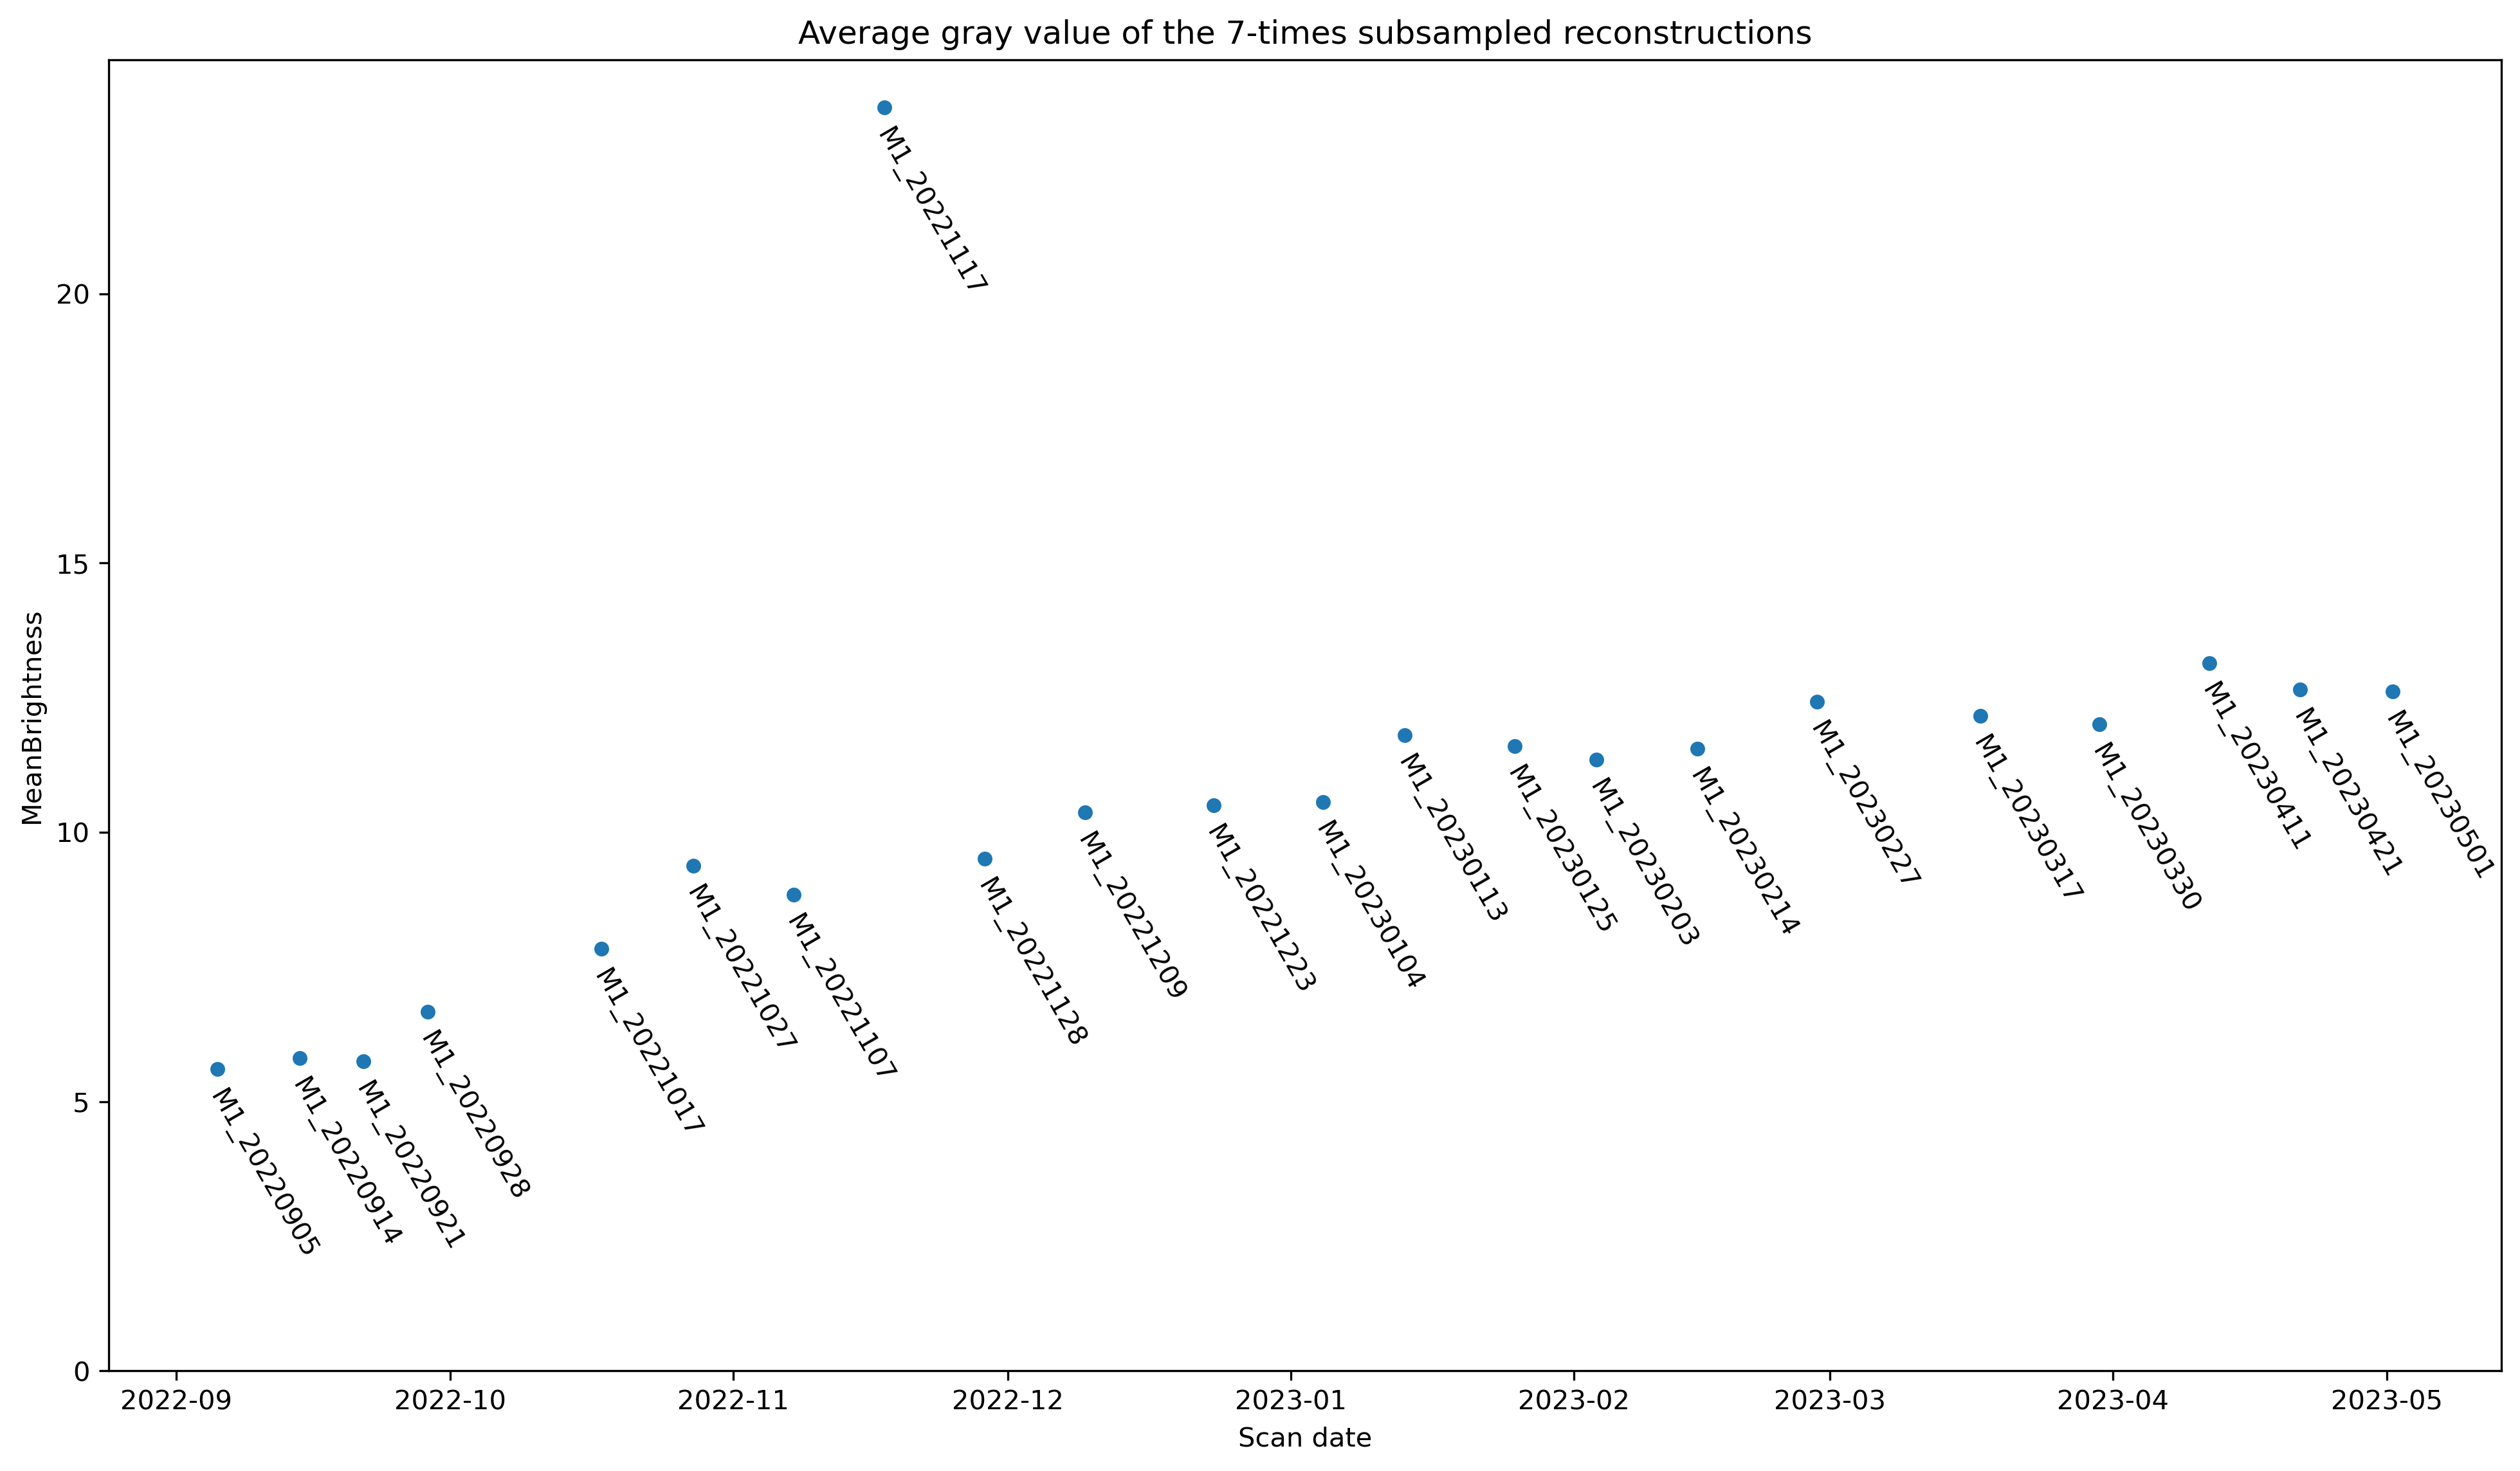

In [187]:
# Plot the mean brightness of the scan with their dates
seaborn.scatterplot(data=Data,
                    x='Scan date',
                    y='MeanBrightness',
                    # size='MeanBrightness'
                   )
# Label text: https://matplotlib.org/stable/tutorials/text/annotations.html
for c,row in Data.iterrows():
    plt.gca().annotate(row.Sample.replace('Mouse01', 'M1').replace('_Lugol_15pct', '').replace('_Nativ', ''),
                       xy=(row['Scan date'], row.MeanBrightness),
                       xycoords='data',
                       xytext=(-5, -70),
                       textcoords='offset points',
                       rotation=-60)
    
    
plt.ylim(ymin=0)
plt.title('Average gray value of the %s-times subsampled reconstructions' % subsample)
plt.savefig(os.path.join(OutPutDir,
                         'MeanBrightness.%s.png' % Data.SampleName.unique()[0]),
            transparent=True,
            bbox_inches='tight')
plt.show()

In [ ]:
for direction in directions:
    # Show each directional middle slice, concatenated
    # Concatenate figures with GridSpec
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-multicolumn-py
    # Set up figure
    fig = plt.figure(figsize=(len(Data)*3,3), constrained_layout=False)
    gs = GridSpec(1,len(Data), figure=fig, wspace=0, hspace=0)
    # plot the selected images
    for c,row in Data.iterrows():
        fig.add_subplot(gs[0, c])
        plt.imshow(row['Mid_%s' % direction].squeeze())
        plt.gca().add_artist(ScaleBar(row['Voxelsize'],'um'))
        plt.title('%s at day %s\n%s' % (row['SampleName'], row['Days passed'].days,
                                        direction + ' Middle slice'))
        plt.axis('off')
    plt.savefig(os.path.join(Root, 'Mouse01.Mid_%s.png' % direction),
                transparent=False,
                bbox_inches='tight')
    plt.show()

In [ ]:
for direction in directions:
    # Show each directional MIP, concatenated
    fig = plt.figure(figsize=(len(Data)*3,3), constrained_layout=False)
    gs = GridSpec(1,len(Data), figure=fig, wspace=0, hspace=0)
    # plot the selected images
    for c,row in Data.iterrows():
        fig.add_subplot(gs[0, c])
        plt.imshow(row['MIP_%s' % direction].squeeze())
        plt.gca().add_artist(ScaleBar(row['Voxelsize'],'um'))
        plt.title('%s at day %s\n%s' % (row['SampleName'],
                                        row['Days passed'].days,
                                        direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(Root, 'Mouse01.MIP_%s.png' % direction),
                transparent=False,
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show one slice of each of the scans, concatenated
iteration = 300
for whichslice in range(iteration, Data['Number of reconstructions'][0] - iteration, iteration):
    # Concatenate figures with GridSpec
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-multicolumn-py
    from matplotlib.gridspec import GridSpec
    # Set up figure
    fig = plt.figure(figsize=(len(Data)*3,3), constrained_layout=False)
    gs = GridSpec(1,len(Data), figure=fig, wspace=0, hspace=0)
    # plot the selected images
    for c,row in Data.iterrows():
        fig.add_subplot(gs[0, c])
        plt.imshow(Reconstructions[c][whichslice])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'],'um'))
        plt.title('%s at day %s\nReconstruction %s' % (row['SampleName'],
                                                       row['Days passed'].days,
                                                       whichslice))
        plt.axis('off')
    plt.savefig(os.path.join(Root, 'Mouse01.Slice%04d.png' % whichslice),
                transparent=False,
                bbox_inches='tight')
    plt.show()

In [ ]:
# Write out GIF of progression
for direction in directions:
    # Concatenate directional MIPs into a GIF
    # Since we `dask`ed the images, we first need to compute them...
    mipseries = [mip.squeeze() for mip in Data['MIP_%s' % direction]]
    imageio.mimwrite('Mouse01.Animation.MIP.%s.gif' % direction, mipseries, format= '.gif', fps = 1)
    # Concatenate directional middle images into a GIF
    # Since we `dask`ed the images, we first need to compute them...
    midseries = [mid.squeeze() for mid in Data['Mid_%s' % direction]]
    imageio.mimwrite('Mouse01.Animation.Middle.%s.gif' % direction, midseries, format= '.gif', fps = 1)

In [ ]:
# Calculate the histograms of one of the MIPs (or reconstructions, depending on which line we comment)
# Caveat: dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Data['Histogram'] = [dask.array.histogram(dask.array.array(mip.squeeze()),
                                          bins=2**8,
                                          range=[0, 2**8]) for mip in Data['MIP_Coronal']]  
# Data['Histogram'] = [dask.array.histogram(rec,
#                                           bins=2**8,
#                                           range=[0, 2**8]) for rec in Reconstructions]
# Actually compute the data and put only h into the dataframe, since we use it quite often below.
# Discard the bins
Data['Histogram'] = [h.compute() for h,b in Data['Histogram']] 

In [ ]:
for c, row in Data.iterrows():
    print(row.Sample, row.Scan, row.Histogram[0])

In [ ]:
for c, row in sorted(Data.iterrows()):
    plt.semilogy(row.Histogram, label='%s/%s' % (row.Sample, row.Scan))
    plt.xlim([0, 255])
    plt.legend()
    plt.show()

In [ ]:
def overeexposecheck(item, threshold=222, howmanypercent=0.1, whichone='Coronal', verbose=False):
    '''Function to check if a certain amount of voxels are brighter than a certain value'''
    if (Data['MIP_%s' % whichone][item]>threshold).sum() > (Data['MIP_%s' % whichone][item].size * howmanypercent / 100):
        if verbose:
            plt.imshow(Data['MIP_%s' % whichone][item].squeeze())
            plt.imshow(numpy.ma.masked_equal(Data['MIP_%s' % whichone][item].squeeze()>threshold, False),
                       cmap='viridis_r',
                       alpha=.618)
            plt.title('%s/%s\n%s px of %s Mpixels (>%s%%) are brighter '
                      'than %s' % (Data['Sample'][item],
                                   Data['Scan'][item],
                                   (Data['MIP_%s' % whichone][item]>threshold).sum().compute(),
                                   round(1e-6 * Data['MIP_%s' % whichone][item].size,2),
                                   howmanypercent,
                                   threshold))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][item],
                                          'um'))
            plt.show()
        return(True)
    else:
        return(False)    

In [ ]:
# Check if 'too much' of the MIP is overexposed
Data['OverExposed'] = [overeexposecheck(c,
                                        whichone='Coronal',
                                        verbose=True) for c, row in Data.iterrows()]

In [ ]:
print('At the moment, we have previewed %s *Mouse* scans of %s samples in %s' % (len(Data),
                                                                                 len(Data.Sample.unique()),
                                                                                 Root))